# Chapter 16. Generalized Linear Madness

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax, random
from jax.experimental.ode import odeint
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import print_summary
from numpyro.infer import MCMC, NUTS, Predictive

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

### Code 16.1

In [2]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1

# scale observed variables
d["w"] = d.weight / d.weight.mean()
d["h"] = d.height / d.height.mean()

### Code 16.2

In [3]:
def model(h, w=None):
    p = numpyro.sample("p", dist.Beta(2, 18))
    k = numpyro.sample("k", dist.Exponential(0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = jnp.log(3.141593 * k * p ** 2 * h ** 3)
    numpyro.sample("w", dist.LogNormal(mu, sigma), obs=w)


m16_1 = MCMC(NUTS(model), 500, 500, num_chains=4)
m16_1.run(random.PRNGKey(0), d.h.values, d.w.values)

### Code 16.3

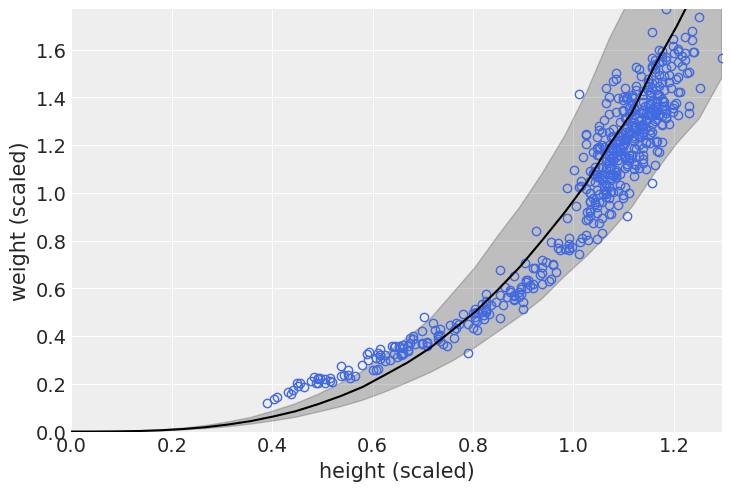

In [4]:
h_seq = jnp.linspace(0, d.h.max(), num=30)
w_sim = Predictive(model, m16_1.get_samples())(random.PRNGKey(1), h=h_seq)["w"]
mu_mean = jnp.mean(w_sim, 0)
w_CI = jnp.percentile(w_sim, q=(5.5, 94.5), axis=0)
plt.plot(d.h, d.w, "o", c="royalblue", mfc="none")
plt.gca().set(
    xlim=(0, d.h.max()),
    ylim=(0, d.w.max()),
    xlabel="height (scaled)",
    ylabel="weight (scaled)",
)
plt.plot(h_seq, mu_mean, "k")
plt.fill_between(h_seq, w_CI[0], w_CI[1], color="k", alpha=0.2)
plt.show()

### Code 16.4

In [5]:
Boxes = pd.read_csv("../data/Boxes.csv", sep=";")
print_summary(dict(zip(Boxes.columns, Boxes.values.T)), 0.89, False)


                      mean       std    median      5.5%     94.5%     n_eff     r_hat
             age      8.03      2.50      8.00      5.00     12.00     13.16      1.10
         culture      3.75      1.96      3.00      1.00      6.00      5.27      1.27
          gender      1.51      0.50      2.00      1.00      2.00    288.12      1.00
  majority_first      0.48      0.50      0.00      0.00      1.00    798.44      1.00
               y      2.12      0.73      2.00      1.00      3.00    655.60      1.00



### Code 16.5

In [6]:
Boxes.y.value_counts(sort=False) / Boxes.y.shape[0]

1    0.211447
2    0.456280
3    0.332273
Name: y, dtype: float64

### Code 16.6

In [7]:
with numpyro.handlers.seed(rng_seed=7):
    N = 30  # number of children

    # half are random
    # sample from 1,2,3 at random for each
    y1 = jnp.array([1, 2, 3])[
        numpyro.sample("y1", dist.Categorical(logits=jnp.ones(3)).expand([N // 2]))
    ]

    # half follow majority
    y2 = jnp.repeat(2, N // 2)

    # combine and shuffle y1 and y2
    rng = numpyro.sample("rng", dist.PRNGIdentity())
    y = random.permutation(rng, jnp.concatenate([y1, y2]))

    # count the 2s
    print(jnp.sum(y == 2) / N)

0.7


### Code 16.7

In [8]:
def Boxes_model(N, y, majority_first):
    # prior
    p = numpyro.sample("p", dist.Dirichlet(jnp.repeat(4, 5)))

    # probability of data
    phi = [None] * 5
    phi[0] = jnp.where(y == 2, 1, 0)  # majority
    phi[1] = jnp.where(y == 3, 1, 0)  # minority
    phi[2] = jnp.where(y == 1, 1, 0)  # maverick
    phi[3] = jnp.repeat(1.0 / 3.0, N)  # random
    phi[4] = jnp.where(
        majority_first == 1,  # follow first
        jnp.where(y == 2, 1, 0),
        jnp.where(y == 3, 1, 0),
    )

    # compute log( p_s * Pr(y_i|s )
    for j in range(5):
        phi[j] = jnp.log(p[j]) + jnp.log(phi[j])
    # compute average log-probability of y
    numpyro.factor("logprob", logsumexp(jnp.stack(phi, axis=1), axis=1))

### Code 16.8

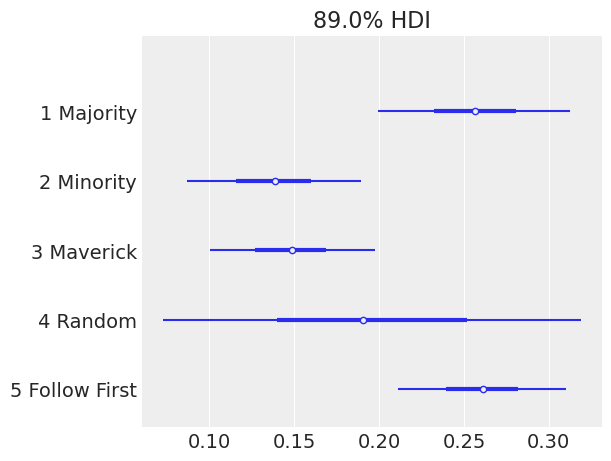

In [9]:
# prep data
dat_list = dict(
    N=Boxes.shape[0], y=Boxes.y.values, majority_first=Boxes.majority_first.values
)

# run the sampler
m16_2 = MCMC(NUTS(Boxes_model), 1000, 1000, num_chains=3)
m16_2.run(random.PRNGKey(0), **dat_list)

# show marginal posterior for p
p_labels = ["1 Majority", "2 Minority", "3 Maverick", "4 Random", "5 Follow First"]
az.plot_forest(
    m16_2.get_samples(group_by_chain=True), combined=True, var_names="p", hdi_prob=0.89,
)
plt.gca().set_yticklabels(p_labels[::-1])
plt.show()

### Code 16.9

In [10]:
Panda_nuts = pd.read_csv("../data/Panda_nuts.csv", sep=";")

### Code 16.10

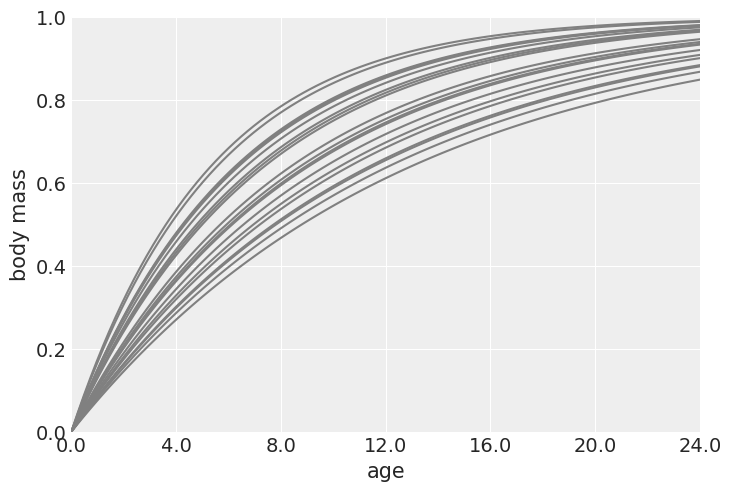

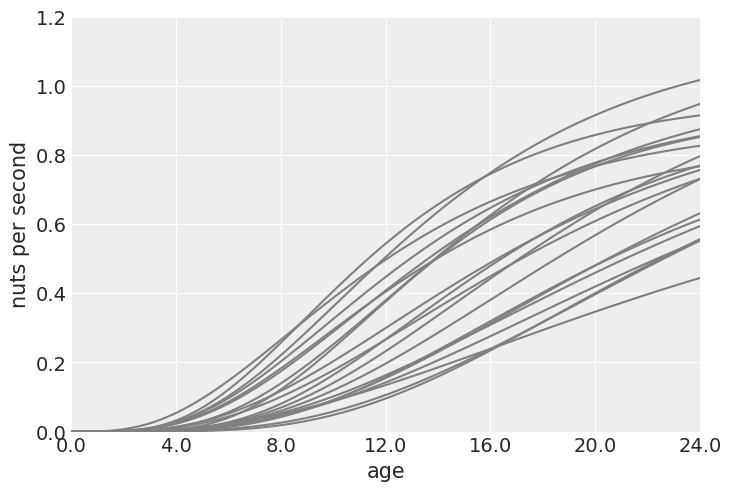

In [11]:
N = int(1e4)
phi = dist.LogNormal(jnp.log(1), 0.1).sample(random.PRNGKey(0), (N,))
k = dist.LogNormal(jnp.log(2), 0.25).sample(random.PRNGKey(1), (N,))
theta = dist.LogNormal(jnp.log(5), 0.25).sample(random.PRNGKey(2), (N,))

# relative grow curve
ax = plt.subplot(xlim=(0, 1.5), ylim=(0, 1), xlabel="age", ylabel="body mass")
at = jnp.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
ax.set(xticks=at, xticklabels=jnp.round(at * Panda_nuts.age.max()))
x = jnp.linspace(0, 1.5, 101)
for i in range(20):
    plt.plot(x, 1 - jnp.exp(-k[i] * x), "gray", lw=1.5)
plt.show()

# implied rate of nut opening curve
ax = plt.subplot(xlim=(0, 1.5), ylim=(0, 1.2), xlabel="age", ylabel="nuts per second")
at = jnp.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
ax.set(xticks=at, xticklabels=jnp.round(at * Panda_nuts.age.max()))
x = jnp.linspace(0, 1.5, 101)
for i in range(20):
    plt.plot(x, phi[i] * (1 - jnp.exp(-k[i] * x)) ** theta[i], "gray", lw=1.5)

### Code 16.11

In [12]:
dat_list = dict(
    n=Panda_nuts.nuts_opened.values,
    age=Panda_nuts.age.values / Panda_nuts.age.max(),
    seconds=Panda_nuts.seconds.values,
)


def model(seconds, age, n):
    phi = numpyro.sample("phi", dist.LogNormal(jnp.log(1), 0.1))
    k = numpyro.sample("k", dist.LogNormal(jnp.log(2), 0.25))
    theta = numpyro.sample("theta", dist.LogNormal(jnp.log(5), 0.25))
    lambda_ = seconds * phi * (1 - jnp.exp(-k * age)) ** theta
    numpyro.sample("n", dist.Poisson(lambda_), obs=n)


m16_4 = MCMC(NUTS(model), 500, 500, num_chains=4)
m16_4.run(random.PRNGKey(0), **dat_list)

### Code 16.12

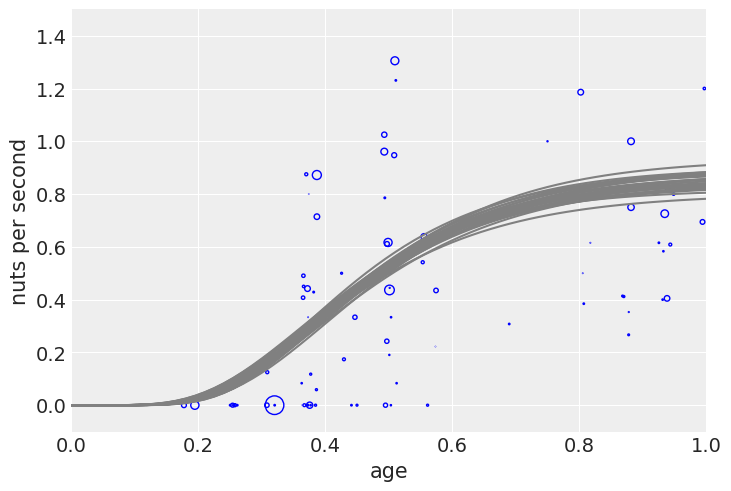

In [13]:
post = m16_4.get_samples()
plt.subplot(xlim=(0, 1), ylim=(-0.1, 1.5), xlabel="age", ylabel="nuts per second")
at = jnp.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
ax.set(xticks=at, xticklabels=jnp.round(at * Panda_nuts.age.max()))

# raw data
pts = dat_list["n"] / dat_list["seconds"]
normalize = lambda x: (x - jnp.min(x)) / (jnp.max(x) - jnp.min(x))
point_size = normalize(dat_list["seconds"])
eps = (dat_list["age"][1:] - dat_list["age"][:-1]).max() / 5
jitter = eps * dist.Uniform(-1, 1).sample(random.PRNGKey(2), dat_list["age"].shape)
plt.scatter(
    dat_list["age"] + jitter,
    pts,
    s=(point_size * 3) ** 2 * 20,
    color="b",
    facecolors="none",
)

# 30 posterior curves
x = jnp.linspace(0, 1.5, 101)
for i in range(30):
    plt.plot(
        x, post["phi"][i] * (1 - jnp.exp(-post["k"][i] * x)) ** post["theta"][i], "gray"
    )
plt.show()

### Code 16.13

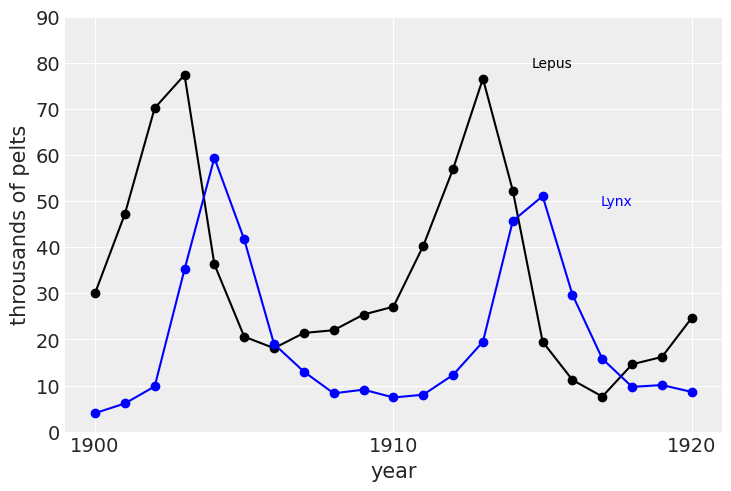

In [14]:
Lynx_Hare = pd.read_csv("../data/Lynx_Hare.csv", sep=";")
plt.plot(jnp.arange(1, 22), Lynx_Hare.iloc[:, 2], "ko-", lw=1.5)
plt.gca().set(ylim=(0, 90), xlabel="year", ylabel="throusands of pelts")
at = jnp.array([1, 11, 21])
plt.gca().set(xticks=at, xticklabels=Lynx_Hare.Year.iloc[at - 1])
plt.plot(jnp.arange(1, 22), Lynx_Hare.iloc[:, 1], "bo-", lw=1.5)
plt.annotate("Lepus", (17, 80), color="k", ha="right", va="center")
plt.annotate("Lynx", (19, 50), color="b", ha="right", va="center")
plt.show()

### Code 16.14

In [15]:
def sim_lynx_hare(n_steps, init, theta, dt=0.002):
    L0 = init[0]
    H0 = init[1]

    def f(val, i):
        H, L = val
        H_i = H + dt * H * (theta[0] - theta[1] * L)
        L_i = L + dt * L * (theta[2] * H - theta[3])
        return (H_i, L_i), (H_i, L_i)

    _, (H, L) = lax.scan(f, (H0, L0), jnp.arange(n_steps - 1))
    H = jnp.concatenate([jnp.expand_dims(H0, -1), H])
    L = jnp.concatenate([jnp.expand_dims(L0, -1), L])
    return jnp.stack([L, H], axis=1)

### Code 16.15

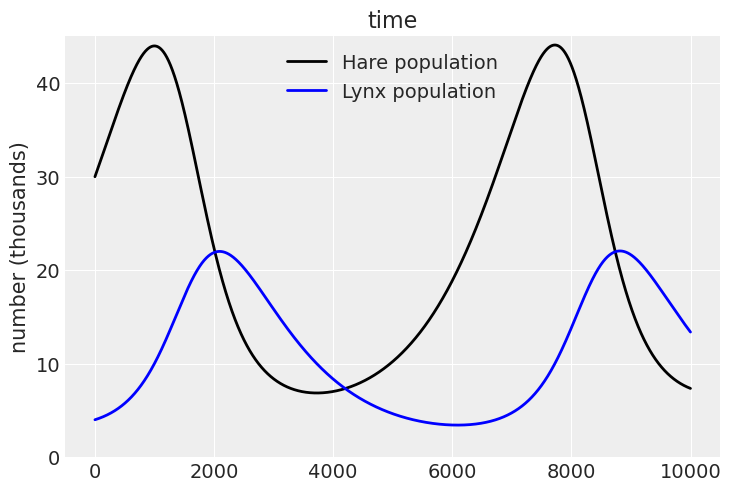

In [16]:
theta = jnp.array([0.5, 0.05, 0.025, 0.5])
z = sim_lynx_hare(int(1e4), Lynx_Hare.values[0, 1:3], theta)

plt.plot(z[:, 1], color="black", lw=2, label="Hare population")
plt.plot(z[:, 0], color="blue", lw=2, label="Lynx population")
plt.gca().set(ylim=(0, jnp.max(z[:, 1]) + 1), ylabel="number (thousands)", xlabel="")
plt.title("time")
plt.legend()
plt.show()

### Code 16.16

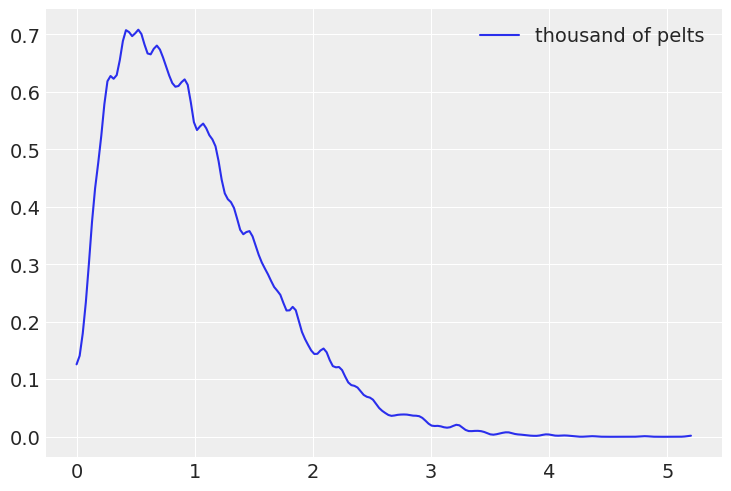

In [17]:
N = int(1e4)
Ht = int(1e4)
p = dist.Beta(2, 18).sample(random.PRNGKey(0), (N,))
h = dist.Binomial(Ht, p).sample(random.PRNGKey(1))
h = jnp.round(h / 1000, 2)
az.plot_kde(h, label="thousand of pelts", bw=1)
plt.show()

### Code 16.17

In [18]:
def dpop_dt(pop_init, t, theta):
    """
    :param t: time
    :param pop_init: initial state {lynx, hares}
    :param theta: parameters
    """
    L, H = pop_init[0], pop_init[1]
    bh, mh, ml, bl = theta[0], theta[1], theta[2], theta[3]
    # differential equations
    dH_dt = (bh - mh * L) * H
    dL_dt = (bl * H - ml) * L
    return jnp.stack([dL_dt, dH_dt])


def Lynx_Hare_model(N, pelts=None):
    """
    :param int N: number of measurement times
    :param pelts: measured populations
    """
    # priors
    # bh,mh,ml,bl
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jnp.tile(jnp.array([1, 0.05]), 2),
            scale=jnp.tile(jnp.array([0.5, 0.05]), 2),
        ),
    )
    # measurement errors
    sigma = numpyro.sample("sigma", dist.Exponential(1).expand([2]))
    # initial population state
    pop_init = numpyro.sample("pop_init", dist.LogNormal(jnp.log(10), 1).expand([2]))
    # trap rate
    p = numpyro.sample("p", dist.Beta(40, 200).expand([2]))

    # N including the first time (initial state)
    times_measured = jnp.arange(float(N))
    pop = numpyro.deterministic(
        "pop",
        odeint(
            dpop_dt, pop_init, times_measured, theta, rtol=1e-5, atol=1e-3, mxstep=500
        ),
    )

    # observation model
    # connect latent population state to observed pelts
    numpyro.sample("pelts", dist.LogNormal(jnp.log(pop * p), sigma), obs=pelts)

### Code 16.18

In [19]:
dat_list = dict(N=Lynx_Hare.shape[0], pelts=Lynx_Hare.values[:, 1:3])

m16_5 = MCMC(NUTS(Lynx_Hare_model, target_accept_prob=0.95), 1000, 1000, num_chains=3)
m16_5.run(random.PRNGKey(0), **dat_list)

### Code 16.19

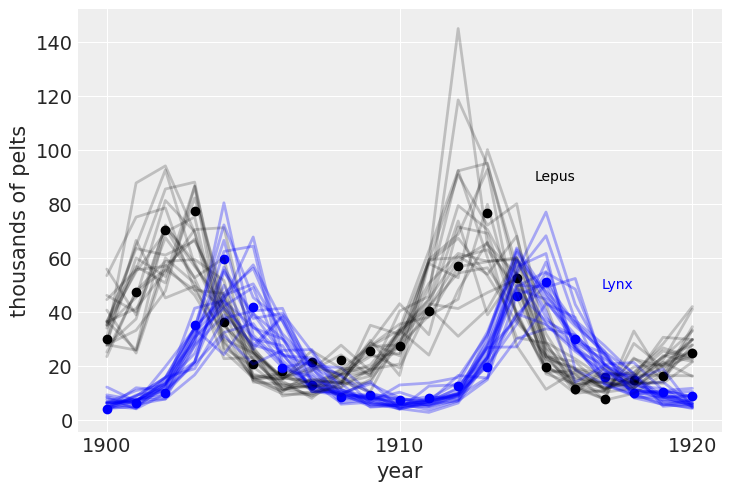

In [20]:
post = m16_5.get_samples()
predict = Predictive(m16_5.sampler.model, post, return_sites=["pelts", "pop"])
post = predict(random.PRNGKey(1), dat_list["N"])
pelts = dat_list["pelts"]
plt.plot(range(1, 22), pelts[:, 1], "ko")
plt.gca().set(xlabel="year", ylabel="thousands of pelts")
at = jnp.array([1, 11, 21])
plt.gca().set(xticks=at, xticklabels=Lynx_Hare.Year.iloc[at - 1])
plt.plot(range(1, 22), pelts[:, 0], "bo")
# 21 time series from posterior
for s in range(21):
    plt.plot(range(1, 22), post["pelts"][s, :, 1], "k", alpha=0.2, lw=2)
    plt.plot(range(1, 22), post["pelts"][s, :, 0], "b", alpha=0.3, lw=2)
# text labels
plt.annotate("Lepus", (17, 90), color="k", ha="right", va="center")
plt.annotate("Lynx", (19, 50), color="b", ha="right", va="center")
plt.show()

### Code 16.20

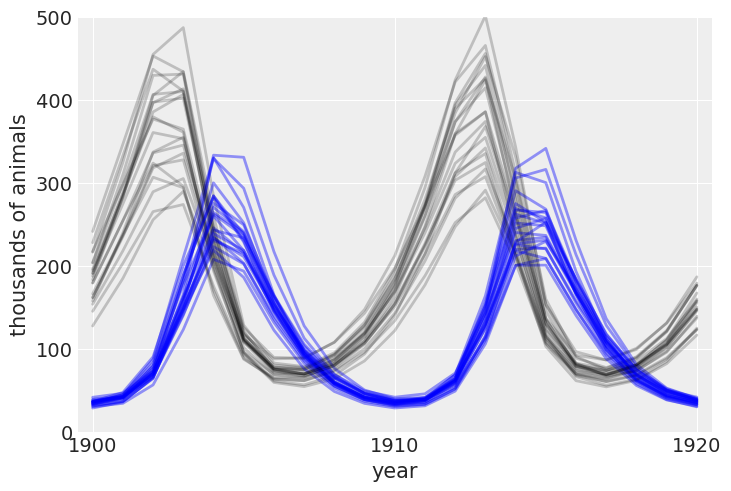

In [21]:
ax = plt.subplot(
    xlim=(0.5, 21.5), ylim=(0, 500), xlabel="year", ylabel="thousands of animals"
)
at = jnp.array([1, 11, 21])
ax.set(xticks=at, xticklabels=Lynx_Hare.Year.iloc[at - 1])
for s in range(21):
    ax.plot(jnp.arange(1, 22), post["pop"][s, :, 1], "k", lw=2, alpha=0.2)
    ax.plot(jnp.arange(1, 22), post["pop"][s, :, 0], "b", lw=2, alpha=0.4)

### Code 16.21

In [22]:
Lynx_Hare = pd.read_csv("../data/Lynx_Hare.csv", sep=";")
dat_ar1 = dict(
    L=Lynx_Hare.Lynx.values[1:],
    L_lag1=Lynx_Hare.Lynx.values[:-1],
    H=Lynx_Hare.Hare.values[1:],
    H_lag1=Lynx_Hare.Lynx.values[:-1],
)